In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from firm import supply
from agent import demand
from optimization import find_equilibrium_prices, error

In [2]:
args = dict(
    n_products = 3,
    n_assets = 2,
    n_firms = 2,
    n_agents = 5000,
    theta = 10.,
    alpha = 5.,
    beta = 5.,
    mean_sigma = 2.,
    var_sigma = 0.1,
    scale = 0.75,
    T = 100,
    max_iter = 1000,
    step_size = 1e-2,
    tol = 1e-12,
    key = jax.random.PRNGKey(1),
)

In [3]:
n_goods = args['n_products'] - args['n_assets']

# a firm is a tuple A, rts, output_idx
A = jax.random.gamma(args['key'], args['theta'], shape=(args['n_firms'], 1))
rts = jax.random.beta(args['key'], args['alpha'], args['beta'], shape=(args['n_firms'], 1))
outputs = jnp.zeros((args['n_firms'], 1))
firms = jnp.concatenate((A, rts, outputs), axis=1)

# An agent is defined by their asset holdings and preference parameter sigma
assets = jnp.exp(args['scale'] * jax.random.normal(args['key'], (args['n_agents'], args['n_assets'])))
sigmas = jnp.clip(args['mean_sigma'] + args['var_sigma'] * jax.random.normal(args['key'], (args['n_agents'], 1)), 1e-5, None)
agents = jnp.concatenate((assets, sigmas), axis=1)

# Define error function
e = error(firms, agents, n_goods, args['T'])

# Define some random starting prices:
# prices = jax.random.normal(key, (n_products,))
prices = jnp.zeros((args['n_products']))

In [4]:
s = supply(jnp.exp(prices), firms)
R = s[1]
assert not jnp.isnan(R)
d = demand(R, jnp.exp(prices), agents, n_goods, args['T'])
err = e(prices)
print(f'(Log) starting prices: {prices}\nSupply: {s[0][0]}\nDemand: {d[0]}\nTherefore, error: {err}')

(Log) starting prices: [0. 0. 0.]
Supply: 218.16085815429688
Demand: 172.45437622070312
Therefore, error: 2089.08251953125


### Distribution of agent wealth (source of heterogeneity)

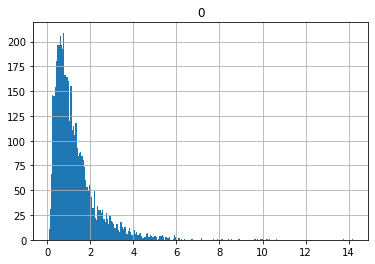

In [5]:
_ = pd.DataFrame(agents[:, 0]).hist(bins=int(args['n_agents']/20))

### Distribution of agent preferences (sigma)

In [ ]:
_ = pd.DataFrame(agents[:, -1]).hist(bins=int(args['n_agents']/20))

Firms are also heterogenous in terms of productivity, but there are only two of them for now so there is not distribution to look at.

### Visual representation of equilibrium

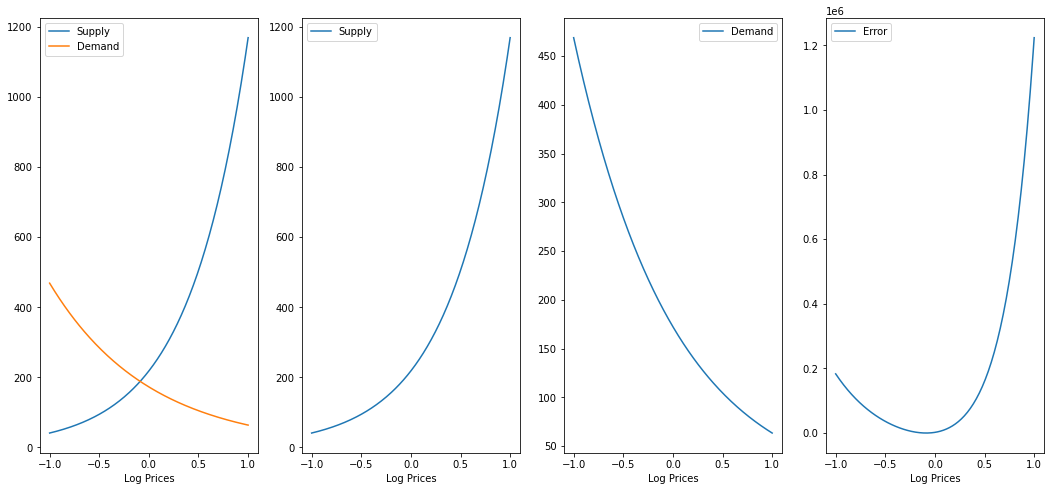

In [6]:
bins = 200
output_prices = jnp.linspace(-1, 1, bins)[:, jnp.newaxis]
input_prices = jnp.repeat(prices[1:][jnp.newaxis], bins, axis=0)
prices_mat = jnp.concatenate((output_prices, input_prices), axis=1)
s = jax.vmap(lambda p: supply(jnp.exp(p), firms))(prices_mat)
do = jax.vmap(lambda r, p: demand(r, jnp.exp(p), agents, n_goods, args['T']))(s[1], prices_mat)
errors = jax.vmap(e)(prices_mat)[:, jnp.newaxis]
so = s[0][:, 0][:, jnp.newaxis]

df = pd.DataFrame(jnp.concatenate([prices_mat[:, 0][:, jnp.newaxis], so, do, errors], axis=1))
df.columns = ['Log Prices', 'Supply', 'Demand', 'Error']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,8))
_ = df.plot(x=0, y=[1, 2], ax=axes[0])
_ = df.plot(x=0, y=[1], ax=axes[1])
_ = df.plot(x=0, y=[2], ax=axes[2])
_ = df.plot(x=0, y=[3], ax=axes[3])

If it looks like the equillibrium will fall in a reasonable area of the problem space, then let's search for it!

In [7]:
eql_log_prices = find_equilibrium_prices(*(args.values()))

iteration: 0
log_prices: [1. 1. 1.]
gradient: [ 49226.25  -24544.375 -24681.87 ]
error: 2089.08251953125
iteration: 10
log_prices: [0.9384465 1.0655931 1.0655886]
gradient: [-19214.738   9573.926   9640.81 ]
error: 382.0838928222656
iteration: 20
log_prices: [0.96440905 1.0369308  1.0368781 ]
gradient: [ 7910.481 -3939.316 -3971.163]
error: 60.25019836425781
iteration: 30
log_prices: [0.95595354 1.0458673  1.0462825 ]
gradient: [-1163.918     594.77924   569.14465]
error: 1.3367023468017578
iteration: 40
log_prices: [0.9558659 1.0456686 1.0466722]
gradient: [-1255.7118   638.568    617.1451]
error: 1.556288242340088
iteration: 50
log_prices: [0.9583958 1.0428655 1.0439528]
gradient: [1432.9144  -728.835   -704.08124]
error: 2.011414051055908
iteration: 60
log_prices: [0.95604956 1.0456812  1.0462598 ]
gradient: [-1063.5786    534.8874    528.69855]
error: 1.1156834363937378
iteration: 70
log_prices: [0.95766944 1.043957   1.0444462 ]
gradient: [ 657.1923  -335.22403 -321.9756 ]
error: 

In [8]:
s = supply(jnp.exp(eql_log_prices), firms)
R = s[1]
assert not jnp.isnan(R)
d = demand(R, jnp.exp(eql_log_prices), agents, n_goods, args['T'])
err = e(eql_log_prices)
print(f'(Log) equilibrium prices: {eql_log_prices}\nSupply: {s[0][0]}\nDemand: {d[0]}\nTherefore, error: {err}')

(Log) equilibrium prices: [-0.04389805  0.04368971  0.04410637]
Supply: 188.27752685546875
Demand: 188.27752685546875
Therefore, error: 0.0
